# Data Analytics - ML25M 

### Imports

In [3]:
import torch
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from torch.utils.tensorboard import SummaryWriter
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


def fix_random(seed: int) -> None:
    """Fix all the possible sources of randomness.

    Args:
        seed: the seed to use. 
    """
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True  # slower

fix_random(42)


## Data Acquisition

movies.csv contains the following fields:

* movieId - a unique identifier for each movie.
* title - the title of the movie.
* genres - a pipe-separated list of genres for the movie.

It will be used to get the movie title and the genres.

In [4]:
movies_df = pd.read_csv('./ml-25m/movies.csv')
genres = movies_df['genres'].str.get_dummies(sep='|')
movies_df = pd.concat([movies_df, genres], axis=1)
movies_df.drop('genres', axis=1, inplace=True)

movies_df.head(3)


,movieId,title,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),0,0,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0


genome-scores.csv contains the following fields:

* movieId - a unique identifier for each movie.
* tagId - a unique identifier for each tag.
* relevance - a score from 0.0 to 1.0 representing the relevance of the tag to the movie.

Combined with the tags.csv file, this will be used to assign tags and their relevance to each movie.

In [5]:
scores_df = pd.read_csv('./ml-25m/genome-scores.csv')
tags_df = pd.read_csv('./ml-25m/genome-tags.csv')
ratings_df = pd.read_csv('./ml-25m/ratings.csv')

df = movies_df.merge(scores_df, on='movieId')
df = df.merge(tags_df, on='tagId')
df = df.pivot_table(index=['movieId', 'title'], columns='tag', values='relevance', fill_value=0).reset_index().rename_axis(None, axis=1)

# average rating for each movie
ratings_df = ratings_df.groupby(['movieId'])['rating'].mean().reset_index()
# round ratings to the nearest 0.5
ratings_df['rating'] = ratings_df['rating'].apply(lambda x: round(x * 2) / 2)

df = ratings_df.merge(df, on='movieId')

# movieId and title are not needed for the model
df.drop(['movieId', 'title'], axis=1, inplace=True)

## Data visualization

In [6]:
df.head(3)

,rating,007,007 (series),18th century,1920s,1930s,1950s,1960s,1970s,1980s,...,world politics,world war i,world war ii,writer's life,writers,writing,wuxia,wwii,zombie,zombies
0,4.0,0.02875,0.02375,0.06250,0.07575,0.14075,0.14675,0.06350,0.20375,0.2020,...,0.04050,0.01425,0.03050,0.035,0.14125,0.05775,0.039,0.02975,0.08475,0.02200
1,3.5,0.04125,0.04050,0.06275,0.08275,0.09100,0.06125,0.06925,0.09600,0.0765,...,0.05250,0.01575,0.01250,0.020,0.12225,0.03275,0.021,0.01100,0.10525,0.01975
2,3.0,0.04675,0.05550,0.02925,0.08700,0.04750,0.04775,0.04600,0.14275,0.0285,...,0.06275,0.01950,0.02225,0.023,0.12200,0.03475,0.017,0.01800,0.09100,0.01775


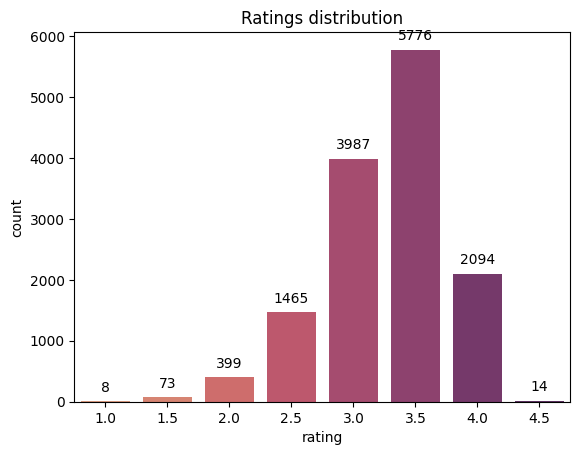

Mean: 3.27
Median: 3.50
Std: 0.50


In [7]:
# Ratings distribution
sns.countplot(x='rating', data=df, palette='flare')
plt.title('Ratings distribution')
for p in plt.gca().patches:
    plt.gca().annotate('{:.0f}'.format(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')
plt.show()

# mean, median, and standard deviation of ratings
print('Mean: {:.2f}'.format(df['rating'].mean()))
print('Median: {:.2f}'.format(df['rating'].median()))
print('Std: {:.2f}'.format(df['rating'].std()))

## Data Preprocessing

In [8]:
N_LABELS = df.rating.nunique()
X = df.drop('rating', axis=1)
Y = df['rating']

# encode Y
Y = LabelEncoder().fit_transform(Y)

lda = LinearDiscriminantAnalysis()
lda.fit(X, Y)

X = lda.transform(X)

# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

print('Training set shape: {}'.format(X_train.shape))

Training set shape: (11052, 7)


## Modeling

### Traditional ML

In [9]:
# Create the model with 100 trees
model = RandomForestRegressor(n_estimators=50,
                                bootstrap = True,
                                max_features = 'sqrt')

# Fit on training data
model.fit(X_train, Y_train)

# accuracy
print('Accuracy:', model.score(X_test, Y_test))

Accuracy: 0.9354213931038139


### Neural Network

In [11]:
writer = SummaryWriter()

# PyTorch Device
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

print('Using device:', device)


Using device: mps


In [ ]:
#hyperparameters
num_epochs = 100  # try 100, 200, 500
learning_rate = 0.01
batch = 32

hidden_size = 32
dropout_prob = 0.2
depth = 2

In [ ]:
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)

train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(Y_train, dtype=torch.long)), batch_size=batch, shuffle=True)
val_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(Y_val, dtype=torch.long)), batch_size=batch, shuffle=True)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(Y_test, dtype=torch.long)), batch_size=batch, shuffle=True)



### Deep Learning for Tabular Data

[PyTorch Tabular](https://github.com/manujosephv/pytorch_tabular#installation)

## Evaluation